# A neural network for recognizing handwritten digits #
### Dilawar Mahmood, 2018 ###

This neural network recognizes human handwritten characters, digits to be precise. The neural network will be using the MNIST Database for handwritten digits to be trained. The end-goal is to have a neural network that can take a handwritten digit as input, and tell the user what digit they just have written.

The YouTube-series "Deep Learning" by 3Blue1Brown and the book "Make Your Own Neural Network" by Tariq Rashid have been a huge help to understanding the mathematics behind neural networks.

In [16]:
import numpy as np
# scipy.special for the sigmoid function expit(), and its inverse logit()
import scipy.special
# scipy.ndimage for rotating image arrays
import scipy.ndimage
import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

In [45]:
# helper to lad data from PNG image file
import imageio
# glob helps select multiple files using patterns
import glob

In [18]:
# neural network class definition
class neuralNetwork:
    
    #initalise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        # self.wih = (np.random.rand(self.hnodes, self.inodes) - 0.5)
        # self.who = (np.random.rand(self.onodes, self.hnodes) - 0.5)
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the target (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
    
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

    # backquery the neural network
    # we'll use the same terminology to each item,
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = np.array(targets_list, ndmin=2).T
    
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)
    
        # calculate the signal out of the hidden layer
        hidden_outputs = np.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
    
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
    
        # calculate the signal out of the input later
        inputs = np.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .00
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
    
        return inputs

In [90]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 300
output_nodes = 10

# learning rate is 0.01
learning_rate = 0.01

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [27]:
# load the mnist training data CSV file into a list
training_data_file = open("mnist_dataset/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [91]:
# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 10

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the records by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
        # create rotated variations
        # rotated anticlockwise by 10 degrees
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28, 28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        #rotated clockwise by 10 degrees
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28, 28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)

In [92]:
# load the mnist test data CSV file into a list
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [93]:
# test the neural network

# scoreboard for how well the network performs, initially empty
scoreboard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    print(correct_label, "correct label")
    # scale and shift the inputs
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    print(label, "network's answer")
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scoreboard
        scoreboard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scoreboard
        scoreboard.append(0)

7 correct label
7 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
0 correct label
0 ne

2 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
8

0 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
4 correct label
9 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
0

7 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
9 correct label
3 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
4 correct label
6 network's answer
5 correct label
5 network's answer
3 correct label
8 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
8

7 correct label
7 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
2 correct label
2 ne

9 correct label
9 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
2 correct label
6 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
7 correct label
7 ne

5 correct label
5 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
2 correct label
3 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
5 correct label
5 ne

0 correct label
0 network's answer
6 correct label
6 network's answer
2 correct label
0 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
3 correct label
7 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
4 correct label
4 ne

4 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
7

9 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
7 correct label
4 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
7

3 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
9

5 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
9 correct label
3 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
7 correct label
0 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
3

1 network's answer
9 correct label
9 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
8

3 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
8 correct label
7 network's answer
7

1 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
8 correct label
2 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
8

4 correct label
4 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
9 correct label
9 ne

4 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
2

9 network's answer
8 correct label
8 network's answer
7 correct label
9 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
5

2 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
6

8 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
8

0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
7 correct label
7 ne

2 correct label
2 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
8 correct label
8 ne

6 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6

0 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
5

8 network's answer
7 correct label
7 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3

9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
0

9 correct label
9 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
1 correct label
1 ne

6 correct label
6 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
1 correct label
1 ne

9 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
8

9 correct label
9 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 ne

2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
6 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
4

6 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2

In [95]:
print(scoreboard)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [94]:
# calculate the performance score, the fraction of correct answers
scoreboard_array = np.asarray(scoreboard)
print("performance = {} %".format(scoreboard_array.sum() / len(scoreboard_array) * 100))

performance = 98.11999999999999 %


In [116]:
# my own image test data set
my_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob('my_own_images/2828_my_own_?.png'):
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print("loading ...", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(np.min(img_data))
    print(np.max(img_data))
    
    # append label and image data to test data set
    record = np.append(label, img_data)
    my_own_dataset.append(record)

loading ... my_own_images\2828_my_own_0.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_1.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_2.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_3.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_4.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_5.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_6.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_7.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_8.png
0.008059238
0.9980593
loading ... my_own_images\2828_my_own_9.png
0.008059238
0.9980593


[[1.53881982e-02]
 [7.65518614e-02]
 [9.95870468e-01]
 [2.62583951e-03]
 [3.53189832e-03]
 [7.33966216e-03]
 [2.41164962e-02]
 [7.26785016e-04]
 [1.20406340e-03]
 [1.00700140e-02]]
the network says 2
correct!


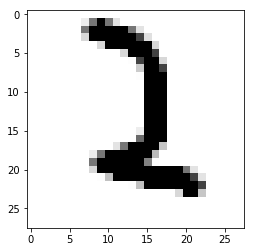

In [129]:
# test the neural network with our own images

# record to test
item = 2

# plot image
matplotlib.pyplot.imshow(my_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = my_own_dataset[item][0]
# data is remaining values
inputs = my_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print(outputs)

# the index of the highest value corresponds to the label
label = np.argmax(outputs)
print("the network says", label)
# append correct or incorrect to list
if (label == correct_label):
    print("correct!")
else:
    print("wrong!")

[0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


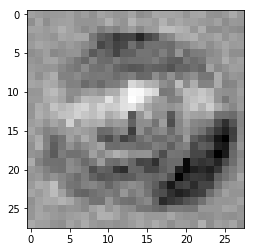

In [130]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 2
# create the output signals for this label
targets = np.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28, 28), cmap='Greys', interpolation='None')